<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# MSDS 7331
## Classification and Regression

###  Glenn Oswald & Ian Kinskey

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# Introduction

## Tasks

In this notebook, we pursue two tasks:
 - **Classification**:  
 Predict whether the level of police incidents (per 25,000 residents) is high or low at a threshold of 21 incidents, for a given postal code and date.  
 
 
 - **Regression**:  
 Predict the level of police incidents (per 25,000 residents) as a continuous variable.  
 

## Scenario

The Austin Police Department would like to predict the level of crime incidents by postal code for the period September 15, 2015 to December 15, 2015. The APD will use this information to make better decisions on how and where to staff their police officers throughout the city.  We are also provided highly accurate forecasts for daily weather (precipitation and temperature), key economic indicators, and population estimates, which we use in order to make our predictions.

We will use the first 57 months of the the data (January 2011 through September 2015) for training and testing models.  We will then validate those models against the final three months of data (September 2015 through December 2015).
![](img/lab-2-train-test-validate-split.png)

---
## Evaluation Metrics

### Classification  

The level of incidents—low and high—with a threshold of 17 daily inicidents per 25,000 population is used as our binary response.  The low daily incident and high daily incident classes are imbalanced at a rate of 3:1, respectively.  That is 75% low incidnets and 25% high incidents. As with most classifiers, accuracy is our ultimate objective.  However, due to imbalanced classes, we must take precautions to ensure our classifiers are not incentivized to predict for the majority class. Later in this notebook, we re-examine the class imbalance of our binary response.

![](img/class-imbalance.png) 

As our scorer, we use the "composite score" which is the geometric mean of accuracy and true positive rate.  The formulas are as follows:

$$accuracy = \frac{true \ positives + true \ negatives}{count \ of \ all \ predictions}$$  
$$true \ positive \ rate = \frac{true \ positives}{true \ positives + false \ negatives}$$  
$$composite \ score = \sqrt{(1 + accuracy)(1 + true \ positive \ rate)} - 1$$

### Regression  

Our primary goal for the regression is the accurate prediction of the level of police incidents in the form of minimal prediction errors.  Explanation is of a secondary importance, and thus statistics such as $R^2$, which explain variance, are not principally useful.  Instead, we opt for a risk metric in the units of the response. We choose the mean absolute error ($MAE$) statistic for this purpose, calculated as follows:

$$MAE = \frac{1}{n}\sum_{i=1}^n\vert y_i-\hat{y}_i\vert$$

This statistic is chosen over the root mean square error statistic ($RMSE$).  Functions for calculating both statistics are available as metrics in the scikit learn package, and $RMSE$ is the more commonly used when reporting average model performance error.  However, the literature shows that the $RMSE$ is an inappropriate measure of average error for us to use as it is a function of three sets of errors.  $RMSE$ changes with 1) the variance of the distribution of error magnitudes, 2) the square root of the number of errors ($\sqrt{n}$), and 3) the average error magnitude.  These three sources of errors make determining the cause of the change in magnitude of the $RMSE$ ambiguous, whereas the $MAE$ only varies with the magnitudes of the errors. [7][8][9]

$MAE$ has the additional benefit of being expressed in the units of the original data (i.e. level of daily incidents per 25,000 residents) and thus would be easier to understand for non-technical APD personnel when explaining the model.

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# Data Preparation
---

## Import Data

First, we'll import a few packages fundamental to all subsequent operations.

In [1]:
import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

Next, we create a dictionary containing the names and data types of the columns of the data we will use for our analysis.

In [2]:
df_types = {'incident_rep_no':np.int64
            ,'crime_type':object
            ,'address':object
            ,'latitude':np.float64
            ,'longitude':np.float64
            ,'consumer_price_index_tx':np.float64
            ,'nonfarm_employment_tx':np.float64
            ,'unemployment_tx':np.float64
            ,'single_family_building_permits_tx':np.int64
            ,'multi_family_building_permits_tx':np.int64
            ,'existing_single_family_home_sales_tx':np.int64
            ,'existing_single_family_home_price_tx':np.int64
            ,'non_residential_building_construction':np.float64
            ,'total_sales_tax_collections_retail_tx':np.float64
            ,'total_sales_tax_collections_tx':np.float64
            ,'retail_gasoline_price_tx':np.float64
            ,'retail_diesel_price_tx':np.float64
            ,'precipitation_inches':np.float64
            ,'mean_temp_f':np.float64
            ,'route_short_name':object
            ,'neighborhood_short_name':object
            ,'postal_code_short_name':object
            ,'locality_short_name':object
            ,'estimate_total_population':np.float64
            ,'date':object,'day_of_month':np.int64
            ,'month':np.int64
            ,'year':np.int64
            ,'dow':np.int64
            ,'hour':np.int64
            ,'minute':np.int64
            ,'crime_group':object
            ,'crime_subgroup':object
            ,'violent':np.int64
            ,'sexual':np.int64
            ,'postal_code':object
            ,'square_miles':np.float64
            ,'square_feet':np.float64}


Set the data path.

In [3]:
from pathlib import Path

rel_path = Path('data/processed/apd-incidents-consolidated-proc-v2.txt')
data_path = Path.cwd() / rel_path

In [4]:
df = pd.read_csv(data_path
                ,sep=";"
                ,encoding='utf-8'
                ,dtype=df_types
                ,parse_dates=['date'])

In [5]:
df.head()

,incident_rep_no,crime_type,address,latitude,longitude,consumer_price_index_tx,nonfarm_employment_tx,unemployment_tx,single_family_building_permits_tx,multi_family_building_permits_tx,...,dow,hour,minute,crime_group,crime_subgroup,violent,sexual,postal_code,square_miles,square_feet
0,20114,CRED CARD ABUSE - OTHER,6917 CARWILL DR,30.301461,-97.644466,203.057,10.5293,7.8,6355,2044,...,1,12,25,PROPERTY,THEFT/BURGLARY,0,0,78724,24.395,680093568.0
1,2011801773,POSS/PROMO CHILD PORNOGRAPHY,3404 S US 183 HWY SB,30.200220,-97.684349,203.057,10.5293,7.8,6355,2044,...,1,19,9,PERSONAL,PUBLIC_NUISANCE,0,1,78744,21.398,596542003.2
2,2011802131,THEFT,9905 N LAMAR BLVD,30.368549,-97.693075,203.057,10.5293,7.8,6355,2044,...,1,0,29,PROPERTY,THEFT/BURGLARY,0,0,78753,10.967,305742412.8
3,2011802239,AGG ASLT STRANGLE/SUFFOCATE,7211 EASY WIND DR,30.340454,-97.718838,203.057,10.5293,7.8,6355,2044,...,1,23,3,PERSONAL,ASSAULT,1,0,78752,3.343,93197491.2
4,2011802274,FAMILY DISTURBANCE,1435 MANFORD HILL DR,30.358825,-97.671299,203.057,10.5293,7.8,6355,2044,...,1,23,24,PERSONAL,THREATS_AND_HARASSMENT,0,0,78753,10.967,305742412.8


---
## Drop Features

Next, we drop variables that we no longer need, either because they are irrelevant to our analysis, no longer necessary after the creation of new variables, or might contain information about the response and thus might leak the "answer into the question."

In [6]:
df.drop(['incident_rep_no' # unique identifer of rows not needed for this analysis
              ,'crime_type' # irrelevant to this analysis (too granular)
              ,'address' # irrelevant to this analysis (too granular)
              ,'latitude' # irrelevant to this analysis (too granular)
              ,'longitude' # irrelevant to this analysis (too granular)
              ,'route_short_name' # irrelevant to this analysis (too granular)
              ,'neighborhood_short_name' # irrelevant to this analysis (too granular)
              ,'locality_short_name' # all incidents occur in Austin, rendering this column useless
              ,'crime_group' # not of interest here (too granular i.e. incident specific)
              ,'crime_subgroup' # not of interest here (too granular i.e. incident specific)
              ,'sexual' # not of interest here (too granular i.e. incident specific)
              ,'violent' # not of interest here (too granular i.e. incident specific)
              ,'date' # redundant w.r.t. day, month, and year cols
              ,'hour' # too granular (aggregation is to the day level)
              ,'minute' # too granular (aggregation is to the day level)
              ,'square_miles'] # redundant with square feet
              ,axis=1
              ,inplace=True)

---

## Create Features & Response

In our mini-lab analysis, population size (or variables which may have encoded information about population size) was an important variable.  However, that analysis did not control for the disparate magnitudes of the geographic areas of postal codes.  For this analysis, we will calculate the estimate population _per 100,000 square feet_.  100,000 square feet was chosen as it approximates the typical area of one city block. 

In [7]:
df['population_per_100ksqft'] = df['estimate_total_population'] / df['square_feet'] * 100000.0

Next, we group our data such that each row will correspond to a single day and postal code.

In [8]:
# group by columns
grp_cols = ['consumer_price_index_tx'
            ,'nonfarm_employment_tx'
            ,'unemployment_tx'
            ,'single_family_building_permits_tx'
            ,'multi_family_building_permits_tx'
            ,'existing_single_family_home_sales_tx'
            ,'existing_single_family_home_price_tx'
            ,'non_residential_building_construction'
            ,'total_sales_tax_collections_retail_tx'
            ,'total_sales_tax_collections_tx'
            ,'retail_gasoline_price_tx'
            ,'retail_diesel_price_tx'
            ,'precipitation_inches'
            ,'mean_temp_f'
            ,'postal_code'
            ,'estimate_total_population'
            ,'day_of_month'
            ,'month'
            ,'year'
            ,'dow'
            ,'population_per_100ksqft']

# execute group by function
df_grp = df.groupby(grp_cols).size().reset_index()

Notice that our aggregation has created a new, untitled column.  This column is the basis of the targets for both our regression and classification tasks.  We next give it an appropriate name:  `daily_incident_count`.

In [9]:
# rename new column to daily incident count
df_grp.rename(columns = {0:'daily_incident_count'}, inplace=True)

Much as we did for the estimated populations of each postal code, we will need to adjust `daily_incident_count` for the population size of the postal code.  We can think of this as a sort of "crime density".  We will call this column, which will be our response for the regression task, `daily_incidents_per_25k_population`.

In [10]:
df_grp['daily_incidents_per_25k_population'] = df_grp['daily_incident_count'] / df_grp['estimate_total_population'] * 25000

25,000 was chosen as the rate as it is the mean estimated population for postal codes in Austin, TX.

---
### Classification Threshold

We will use the 3rd quartile of `daily_incidents_per_25k_population` as our threshold for a high or low daily incident count.

In [11]:
df_grp.describe().T

,count,mean,std,min,25%,50%,75%,max
consumer_price_index_tx,63331.0,211.292436,4.389125,200.713000,207.881000,212.034000,215.610000,217.333000
nonfarm_employment_tx,63331.0,11.258551,0.456858,10.491700,10.838600,11.258800,11.717600,11.944000
unemployment_tx,63331.0,5.952715,1.159166,4.400000,4.700000,6.100000,6.800000,7.900000
single_family_building_permits_tx,63331.0,7125.369993,1429.370805,4237.000000,5910.000000,7195.000000,8200.000000,9704.000000
multi_family_building_permits_tx,63331.0,4676.277400,1615.133502,1256.000000,3532.000000,4529.000000,5676.000000,8851.000000
existing_single_family_home_sales_tx,63331.0,22852.026559,5047.327357,12527.000000,19024.000000,22704.000000,25786.000000,33120.000000
existing_single_family_home_price_tx,63331.0,170060.630323,18428.786342,138000.000000,152900.000000,169950.000000,185000.000000,206000.000000
non_residential_building_construction,63331.0,1911.656253,1250.250666,870.337000,1225.087000,1450.563000,2139.590000,7650.165000
total_sales_tax_collections_retail_tx,63331.0,990.474813,108.117437,808.450000,906.760000,980.838000,1060.485000,1248.526000
total_sales_tax_collections_tx,63331.0,2181.169046,236.487498,1611.356000,2009.907000,2173.682000,2348.382000,2670.476000


As the above shows, Q3 of `daily_incidents_per_25k_population` is approximately $17$.

---
###  Create Binary Response

We use this fact to create the binary response for our classification task.

In [12]:
high_level_of_incidents = 17

df_grp['high_loi'] = np.where(df_grp['daily_incidents_per_25k_population']>=high_level_of_incidents, 1, 0)

### Class Imbalance Plot

As mentioned above, we re-examine the class imbalance.

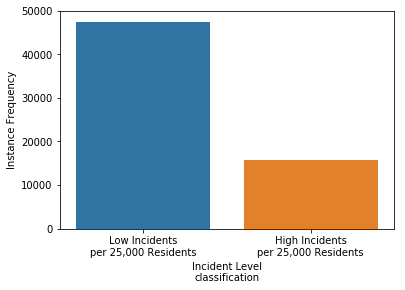

There are 15,786 (25.0%) observations of high incidents 47,545 (75.0%) observations of low incidents


In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline  

g = sns.countplot(x="high_loi", data=df_grp)
g.set(xticklabels=["Low Incidents\nper 25,000 Residents", "High Incidents\nper 25,000 Residents"])
g.set(xlabel='Incident Level\nclassification', ylabel='Instance Frequency')

plt.show()

high_days = np.where(df_grp['high_loi']==1)[0].shape[0]
low_days = np.where(df_grp['high_loi']==0)[0].shape[0]

hd_perc = round(1.0 * high_days / (high_days + low_days), 2) * 100
ld_perc = round(1.0 * low_days / (high_days + low_days),2) * 100

print("There are {high:,d} ({hd_perc}%) observations of high incidents {low:,d} ({ld_perc}%) "
      "observations of low incidents".format(high=high_days
                                          , hd_perc=hd_perc
                                          , low=low_days
                                          , ld_perc=ld_perc))


The class imbalance ratio of 3:1 remains almost identical after transforming our response and modifying the high/low threshold.

---
### Drop More Variables

We drop `daily_incident_count` as it is no longer needed now that we've created `daily_incidents_per_25k_population` and `high_loi`.  We also drop `estimate_total_population` as it is effectively replaced by `population_per_100ksqft`.

In [14]:
df_grp.drop(['daily_incident_count', 'estimate_total_population'] # not needed after feature creation
              ,axis=1
              ,inplace=True)

---
### Create Dummy Variables

We next transform any categorical variables into dummies via one hot encoding.

In [15]:
df_grp = pd.get_dummies(df_grp
                        , columns={"postal_code","day_of_month","month","year","dow"}
                        , prefix={"postal_code":"postal_code_"
                        , "day_of_month":"dom_"
                        , "month":"month_"
                        , "year":"year_"
                        , "dow":"dow_"})

---
### Segregate Validation Data

As noted in the introduction, we will segregate the final 3 months of data in this set for use as a validation set so as to simulate the previously described scenario.

In [16]:
# training & testing set
df_test = df_grp.loc[(df_grp.year__2011.isin([1]) | df_grp.year__2012.isin([1]) | 
                        df_grp.year__2013.isin([1]) | 
                        df_grp.year__2014.isin([1])) | 
                        (df_grp.year__2015.isin([1]) &
                        (df_grp.month__1.isin([1]) |
                        df_grp.month__2.isin([1]) |
                        df_grp.month__3.isin([1]) |
                        df_grp.month__4.isin([1]) |
                        df_grp.month__5.isin([1]) |
                        df_grp.month__6.isin([1]) |
                        df_grp.month__7.isin([1]) |
                        df_grp.month__8.isin([1]) |
                        df_grp.month__9.isin([1])))]

# validation set
df_validate = df_grp.loc[df_grp.year__2015.isin([1]) & 
                         (df_grp.month__10.isin([1]) | 
                          df_grp.month__11.isin([1]) | 
                          df_grp.month__12.isin([1]))]


---
## Scale Features

In order to improve interpretability of our model coefficients (where applicable) we will next standardize features by removing the mean and scaling to unit variance using the `sklearn`'s `StandardScaler` function.  An additional justification for transforming features values to z-scores is that gradient descent (a regression method we employ in this notebook) converges much faster with feature scaling than without it. [1]  Lastly, we will scale features for all models so as to preserve our ability to more easily compare models to one another.

First, we transfer all values to `numpy.ndarray` objects.  Note that we have two separate $y$ arrays.  The first is the continuous variable for the regression task:  `daily_incidents_per_25k_population`.  The second is the binary class variable for the classification task:  `high_loi`.

In [17]:
# train and test set
Xs_trn_tst = df_test.drop(labels=['daily_incidents_per_25k_population','high_loi'], axis=1).values
y_trn_tst_reg = df_test['daily_incidents_per_25k_population'].values
y_trn_tst_clf = df_test['high_loi'].values

# validation set
Xs_val = df_validate.drop(labels=['daily_incidents_per_25k_population','high_loi'], axis=1).values
y_val_reg = df_validate['daily_incidents_per_25k_population'].values
y_val_clf = df_validate['high_loi'].values

Import `StandardScaler` from `sklearn` for conversion of feature values to z-scores.

In [18]:
from sklearn.preprocessing import StandardScaler

Instantiate `StandardScaler` object and fit to data.

In [19]:
scaler = StandardScaler()
scaler.fit(Xs_trn_tst)

StandardScaler(copy=True, with_mean=True, with_std=True)

Transform $Xs$ to z-scores.

In [20]:
Xs_trn_tst_scl = scaler.transform(Xs_trn_tst)
Xs_val_scl = scaler.transform(Xs_val)

---
## Final Data Set Description

In [21]:
print("\nThe working data set comprises {instances} observations and {features} features."
      "\nThere are two response variabels corresponding "
      "to the classification and regression tasks.\n".format(instances=Xs_trn_tst_scl.shape[0], features=Xs_trn_tst_scl.shape[1]))


The working data set comprises 60103 observations and 131 features.
There are two response variabels corresponding to the classification and regression tasks.



| Variable | Data Type | Level of Measurement | Description | Variable Type | 
|  :------ |  :------ |  :------ |  :------ |  :------ | 
| consumer_price_index_tx | float64 | Ratio | Economic indicator measuring the average change over a reference base period of time | Feature | 
| nonfarm_employment_tx | float64 | Ratio | Represents the number of persons who work and are on the payroll of nonagricultural establishments in TX. | Feature | 
| unemployment_tx | float64 | Ratio | Represents a percentage of the civilian labor force that is unemployed in TX. | Feature | 
| single_family_building_permits_tx | int64 | Ratio | Represents data on new privately-owned residential construction. The data only shows information on single-family building permits issued for new construction. The number of permits issued does not necessarily mean that the same number of residential structures will be built. | Feature | 
| multi_family_building_permits_tx | int64 | Ratio | Represents data on new privately-owned residential construction. The data only shows information on multi-family building permits issued for new construction. The number of permits issued does not necessarily mean that the same number of residential structures will be built. | Feature | 
| existing_single_family_home_sales_tx | int64 | Ratio | Total Single Family Home Sales in a one month period in the state of TX. | Feature | 
| existing_single_family_home_price_tx | int64 | Ratio | Median Single Family Home Price over a one month period in the state of TX. | Feature | 
| non_residential_building_construction | float64 | Ratio | The value of construction starts for non-residential construction in the state of TX over a one month period of time. | Feature | 
| total_sales_tax_collections_retail_tx | float64 | Ratio | Total sales tax collected in Texas from retailers over a one month period. | Feature | 
| total_sales_tax_collections_tx | float64 | Ratio | Total sales tax collected in Texas over a one month period. | Feature | 
| retail_gasoline_price_tx | float64 | Ratio | Average price of gasoline at the pump paid by TX consumers. | Feature | 
| retail_diesel_price_tx | float64 | Ratio | Average price paid by TX consumers for diesel fuel at the pump. | Feature | 
| precipitation_inches | float64 | Ratio | Mean daily air temperature on the date of the incident in and around Austin as measured by seven Austin area NOAA weather stations. | Feature | 
| mean_temp_f | float64 | Interval | Mean daily precipitation on the date of the incident in and around Austin as measured by seven Austin area NOAA weather stations. | Feature | 
| population_per_100ksqft | float64 | Ratio | Estimated total population of a given zip code per 100,000 square feet.  Measure of population density. | Feature | 
| dow__0 | uint8 | Interval | Indicator variable for day of week = Sunday | Feature | 
| dow__1 | uint8 | Interval | Indicator variable for day of week = Monday | Feature | 
| dow__2 | uint8 | Interval | Indicator variable for day of week = Tuesday | Feature | 
| dow__3 | uint8 | Interval | Indicator variable for day of week = Wednesday | Feature | 
| dow__4 | uint8 | Interval | Indicator variable for day of week = Thursday | Feature | 
| dow__5 | uint8 | Interval | Indicator variable for day of week = Friday | Feature | 
| dow__6 | uint8 | Interval | Indicator variable for day of week = Saturday | Feature | 
| year__2011 | uint8 | Interval | Indicator variable for year = 2011 | Feature | 
| year__2012 | uint8 | Interval | Indicator variable for year = 2012 | Feature | 
| year__2013 | uint8 | Interval | Indicator variable for year = 2013 | Feature | 
| year__2014 | uint8 | Interval | Indicator variable for year = 2014 | Feature | 
| year__2015 | uint8 | Interval | Indicator variable for year = 2015 | Feature | 
| postal_code__75078 | uint8 | Interval | Indicator variable for postal code = 75078 | Feature | 
| postal_code__78610 | uint8 | Interval | Indicator variable for postal code = 78610 | Feature | 
| postal_code__78612 | uint8 | Interval | Indicator variable for postal code = 78612 | Feature | 
| postal_code__78613 | uint8 | Interval | Indicator variable for postal code = 78613 | Feature | 
| postal_code__78615 | uint8 | Interval | Indicator variable for postal code = 78615 | Feature | 
| postal_code__78616 | uint8 | Interval | Indicator variable for postal code = 78616 | Feature | 
| postal_code__78617 | uint8 | Interval | Indicator variable for postal code = 78617 | Feature | 
| postal_code__78621 | uint8 | Interval | Indicator variable for postal code = 78621 | Feature | 
| postal_code__78641 | uint8 | Interval | Indicator variable for postal code = 78641 | Feature | 
| postal_code__78645 | uint8 | Interval | Indicator variable for postal code = 78645 | Feature | 
| postal_code__78652 | uint8 | Interval | Indicator variable for postal code = 78652 | Feature | 
| postal_code__78653 | uint8 | Interval | Indicator variable for postal code = 78653 | Feature | 
| postal_code__78660 | uint8 | Interval | Indicator variable for postal code = 78660 | Feature | 
| postal_code__78664 | uint8 | Interval | Indicator variable for postal code = 78664 | Feature | 
| postal_code__78665 | uint8 | Interval | Indicator variable for postal code = 78665 | Feature | 
| postal_code__78681 | uint8 | Interval | Indicator variable for postal code = 78681 | Feature | 
| postal_code__78701 | uint8 | Interval | Indicator variable for postal code = 78701 | Feature | 
| postal_code__78702 | uint8 | Interval | Indicator variable for postal code = 78702 | Feature | 
| postal_code__78703 | uint8 | Interval | Indicator variable for postal code = 78703 | Feature | 
| postal_code__78704 | uint8 | Interval | Indicator variable for postal code = 78704 | Feature | 
| postal_code__78705 | uint8 | Interval | Indicator variable for postal code = 78705 | Feature | 
| postal_code__78712 | uint8 | Interval | Indicator variable for postal code = 78712 | Feature | 
| postal_code__78717 | uint8 | Interval | Indicator variable for postal code = 78717 | Feature | 
| postal_code__78719 | uint8 | Interval | Indicator variable for postal code = 78719 | Feature | 
| postal_code__78721 | uint8 | Interval | Indicator variable for postal code = 78721 | Feature | 
| postal_code__78722 | uint8 | Interval | Indicator variable for postal code = 78722 | Feature | 
| postal_code__78723 | uint8 | Interval | Indicator variable for postal code = 78723 | Feature | 
| postal_code__78724 | uint8 | Interval | Indicator variable for postal code = 78724 | Feature | 
| postal_code__78725 | uint8 | Interval | Indicator variable for postal code = 78725 | Feature | 
| postal_code__78726 | uint8 | Interval | Indicator variable for postal code = 78726 | Feature | 
| postal_code__78727 | uint8 | Interval | Indicator variable for postal code = 78727 | Feature | 
| postal_code__78728 | uint8 | Interval | Indicator variable for postal code = 78728 | Feature | 
| postal_code__78729 | uint8 | Interval | Indicator variable for postal code = 78729 | Feature | 
| postal_code__78730 | uint8 | Interval | Indicator variable for postal code = 78730 | Feature | 
| postal_code__78731 | uint8 | Interval | Indicator variable for postal code = 78731 | Feature | 
| postal_code__78732 | uint8 | Interval | Indicator variable for postal code = 78732 | Feature | 
| postal_code__78733 | uint8 | Interval | Indicator variable for postal code = 78733 | Feature | 
| postal_code__78734 | uint8 | Interval | Indicator variable for postal code = 78734 | Feature | 
| postal_code__78735 | uint8 | Interval | Indicator variable for postal code = 78735 | Feature | 
| postal_code__78736 | uint8 | Interval | Indicator variable for postal code = 78736 | Feature | 
| postal_code__78737 | uint8 | Interval | Indicator variable for postal code = 78737 | Feature | 
| postal_code__78738 | uint8 | Interval | Indicator variable for postal code = 78738 | Feature | 
| postal_code__78739 | uint8 | Interval | Indicator variable for postal code = 78739 | Feature | 
| postal_code__78741 | uint8 | Interval | Indicator variable for postal code = 78741 | Feature | 
| postal_code__78742 | uint8 | Interval | Indicator variable for postal code = 78742 | Feature | 
| postal_code__78744 | uint8 | Interval | Indicator variable for postal code = 78744 | Feature | 
| postal_code__78745 | uint8 | Interval | Indicator variable for postal code = 78745 | Feature | 
| postal_code__78746 | uint8 | Interval | Indicator variable for postal code = 78746 | Feature | 
| postal_code__78747 | uint8 | Interval | Indicator variable for postal code = 78747 | Feature | 
| postal_code__78748 | uint8 | Interval | Indicator variable for postal code = 78748 | Feature | 
| postal_code__78749 | uint8 | Interval | Indicator variable for postal code = 78749 | Feature | 
| postal_code__78750 | uint8 | Interval | Indicator variable for postal code = 78750 | Feature | 
| postal_code__78751 | uint8 | Interval | Indicator variable for postal code = 78751 | Feature | 
| postal_code__78752 | uint8 | Interval | Indicator variable for postal code = 78752 | Feature | 
| postal_code__78753 | uint8 | Interval | Indicator variable for postal code = 78753 | Feature | 
| postal_code__78754 | uint8 | Interval | Indicator variable for postal code = 78754 | Feature | 
| postal_code__78756 | uint8 | Interval | Indicator variable for postal code = 78756 | Feature | 
| postal_code__78757 | uint8 | Interval | Indicator variable for postal code = 78757 | Feature | 
| postal_code__78758 | uint8 | Interval | Indicator variable for postal code = 78758 | Feature | 
| postal_code__78759 | uint8 | Interval | Indicator variable for postal code = 78759 | Feature | 
| postal_code__78945 | uint8 | Interval | Indicator variable for postal code = 78945 | Feature | 
| dom__1 | uint8 | Interval | Indicator variable for day of month = 1 | Feature | 
| dom__2 | uint8 | Interval | Indicator variable for day of month = 2 | Feature | 
| dom__3 | uint8 | Interval | Indicator variable for day of month = 3 | Feature | 
| dom__4 | uint8 | Interval | Indicator variable for day of month = 4 | Feature | 
| dom__5 | uint8 | Interval | Indicator variable for day of month = 5 | Feature | 
| dom__6 | uint8 | Interval | Indicator variable for day of month = 6 | Feature | 
| dom__7 | uint8 | Interval | Indicator variable for day of month = 7 | Feature | 
| dom__8 | uint8 | Interval | Indicator variable for day of month = 8 | Feature | 
| dom__9 | uint8 | Interval | Indicator variable for day of month = 9 | Feature | 
| dom__10 | uint8 | Interval | Indicator variable for day of month = 10 | Feature | 
| dom__11 | uint8 | Interval | Indicator variable for day of month = 11 | Feature | 
| dom__12 | uint8 | Interval | Indicator variable for day of month = 12 | Feature | 
| dom__13 | uint8 | Interval | Indicator variable for day of month = 13 | Feature | 
| dom__14 | uint8 | Interval | Indicator variable for day of month = 14 | Feature | 
| dom__15 | uint8 | Interval | Indicator variable for day of month = 15 | Feature | 
| dom__16 | uint8 | Interval | Indicator variable for day of month = 16 | Feature | 
| dom__17 | uint8 | Interval | Indicator variable for day of month = 17 | Feature | 
| dom__18 | uint8 | Interval | Indicator variable for day of month = 18 | Feature | 
| dom__19 | uint8 | Interval | Indicator variable for day of month = 19 | Feature | 
| dom__20 | uint8 | Interval | Indicator variable for day of month = 20 | Feature | 
| dom__21 | uint8 | Interval | Indicator variable for day of month = 21 | Feature | 
| dom__22 | uint8 | Interval | Indicator variable for day of month = 22 | Feature | 
| dom__23 | uint8 | Interval | Indicator variable for day of month = 23 | Feature | 
| dom__24 | uint8 | Interval | Indicator variable for day of month = 24 | Feature | 
| dom__25 | uint8 | Interval | Indicator variable for day of month = 25 | Feature | 
| dom__26 | uint8 | Interval | Indicator variable for day of month = 26 | Feature | 
| dom__27 | uint8 | Interval | Indicator variable for day of month = 27 | Feature | 
| dom__28 | uint8 | Interval | Indicator variable for day of month = 28 | Feature | 
| dom__29 | uint8 | Interval | Indicator variable for day of month = 29 | Feature | 
| dom__30 | uint8 | Interval | Indicator variable for day of month = 30 | Feature | 
| dom__31 | uint8 | Interval | Indicator variable for day of month = 31 | Feature | 
| month__1 | uint8 | Interval | Indicator variable for day of month = 1 | Feature | 
| month__2 | uint8 | Interval | Indicator variable for day of month = 2 | Feature | 
| month__3 | uint8 | Interval | Indicator variable for day of month = 3 | Feature | 
| month__4 | uint8 | Interval | Indicator variable for day of month = 4 | Feature | 
| month__5 | uint8 | Interval | Indicator variable for day of month = 5 | Feature | 
| month__6 | uint8 | Interval | Indicator variable for day of month = 6 | Feature | 
| month__7 | uint8 | Interval | Indicator variable for day of month = 7 | Feature | 
| month__8 | uint8 | Interval | Indicator variable for day of month = 8 | Feature | 
| month__9 | uint8 | Interval | Indicator variable for day of month = 9 | Feature | 
| month__10 | uint8 | Interval | Indicator variable for day of month = 10 | Feature | 
| month__11 | uint8 | Interval | Indicator variable for day of month = 11 | Feature | 
| month__12 | uint8 | Interval | Indicator variable for day of month = 12 | Feature | 
| daily_incidents_per_25k_population | float64 | Ratio | Count of incident occurences by day and postal code per 25,000 residents. | Regression Target | 
| high_loi | int64 | Interval | Binary response variable indicating whether the daily incident count for a given date and postal code exceeded the threshold of 17 incidents per 25,000. | Classification Target | 

---

## Data Split

For our cross validation splitting strategy, we employ stratified $k$-fold cross validation.  In $k$-fold cross-validation the data is first divided into $k$ approximately equal sized folds. Next, $k$ loops of training and testing are performed such that for each loop a different fold of the data is witheld for testing while the other $k - 1$ folds are used for training.

Because our data are imbalanced, the stratified $k$-folds method is superior for our uses. In the $k$-folds method, the subsamples (folds) are selected so as to roughly maintain the class proportions of the whole sample.  In this way training and testing occurs against representative proportions of the two classes.  We selected $k=10$ for the stratified cross validation of our models as this number of folds tends to reduce variance while remaining mostly unbiased.  [2]


The figure below depicts the stratified $k$-fold strategy for our binary class imbalance ratio.

![](img/stratified-k-fold-cv.png)

In [22]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10 # k folds = 10
                      , random_state=24)
skf.get_n_splits(Xs_trn_tst_scl, y_val_reg)

print(skf)

StratifiedKFold(n_splits=10, random_state=24, shuffle=False)


We will utilize this cross validation strategy within a `gridsearchCV` object, which will enable us to exhaustively search a hyperparameter space of our definition for each classifier and regressor while performing stratified k-fold on each model configuration.

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# Classification

---
## Logistic Regression

### General  
Logistic regression is a machine learning and statistical method for making predictions about a binary response using data in which there are one or more independent variables. In this case, the target variable has only two classes (i.e. binary).

### Advantages of Logistic Regression  
 - While target classes must be discrete (i.e. categorical), inputs can be both continuous and categorical (provided they are properly encoded)
 - The logit function produces a probabilistic interpretation, and the algorithm can be regularized to avoid overfitting. [4]
 - When inputs are converted to z-scores, relative importance of features is very easy to interpret
 - Logistic regression will work better if there's a single decision boundary.  In other words, the classes should be linearly separable for best results. [3]
 - Logistic regression is relatively simple when compared to other algorithms, and thus is easier to understand generally
 
### Disadvantages of Logistic Regression
 - Target classes must be discrete.  This is only a disadvantage if the task is one of regression, as classification problems generally have discrete outcomes.
 - Works best when classes are linearly separable.  Said another way, this method does not work well for non-linear data.  Non-linear inputs must be transformed to be linear.
 - Does not perform well with large feature space

---
### Modeling

Import necessary packages.  `GridSearchCV`, `confusion_matrix`, `accuracy_score`, and `auc` will be used for all three classification models.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, roc_curve, auc, recall_score

Create a function to calculation our performance metric ("composite score"). Make a scorer from this function which we can then pass to `GridSearchCV` for scoring each model configuration.

In [24]:
def score_func(y, y_pred, **kwargs):
    acc = np.float64(accuracy_score(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    tp = np.float64(cm[1][1])
    fn = np.float64(cm[1][0])
    tpr = tp / (tp + fn)
    comp_score = np.sqrt((1+acc)*(1+tpr)) - 1
    return comp_score

comp_scorer = make_scorer(score_func=score_func, greater_is_better=True)

Instantiate a logistic regression classifier object.  Note that we pass no parameters to the object as this will occur during the hyperparameter search conducted by the `GridSearchCV` object.

In [25]:
# create the classifier instance
logreg = LogisticRegression()

Establish hyperparameter space to be grid searched.

In [26]:
parameters = {'dual':(True, False)
    , 'C':[0.1,1,10]
    ,'class_weight':[{0: w} for w in [1, 2, 4, 6, 10]]}

Create a `GridSearchCV` object.  In our configuration of this object, we pass it the "blank" logistic regression classifier, the `StratifiedKFold` object where $k = 10$, the hyperparameter object from the previous cell, and the composite scorer we previously created.  Additionally, we instruct the grid search object to execute two jobs simultaneously (i.e. parallel execution).

In [27]:
# create a grid search object
lr_clf = GridSearchCV(estimator=logreg
                   , n_jobs=2 # parallel execution
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=skf # KFolds = 10
                   , scoring=comp_scorer)

Having created our grid search object, we now pass it training data and begin the hyperparameter search.

In [28]:
lr_clf.fit(Xs_trn_tst_scl, y_trn_tst_clf)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed: 12.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=24, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'dual': (True, False), 'C': [0.1, 1, 10], 'class_weight': [{0: 1}, {0: 2}, {0: 4}, {0: 6}, {0: 10}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(score_func), verbose=1)

With our grid search process complete, we can now look at models ranked according to their mean test score (where $n=k=10$).  Our grid search produced 30 models, but we'll just look at the best 10 models.

In [29]:
logreg_results = pd.DataFrame(lr_clf.cv_results_)
logreg_results.sort_values(by="rank_test_score", inplace=True)
headers = ['rank_test_score','mean_test_score','mean_train_score','param_C','param_class_weight','param_dual','std_test_score','std_train_score']
logreg_results[headers].head(10)

,rank_test_score,mean_test_score,mean_train_score,param_C,param_class_weight,param_dual,std_test_score,std_train_score
0,1,0.853842,0.882315,0.1,{0: 1},True,0.041111,0.001948
1,2,0.853810,0.882393,0.1,{0: 1},False,0.041076,0.001925
20,3,0.849904,0.872741,10,{0: 1},True,0.050334,0.010776
10,4,0.849050,0.882862,1,{0: 1},True,0.044233,0.002086
11,5,0.848674,0.882900,1,{0: 1},False,0.043971,0.002290
21,6,0.846895,0.882939,10,{0: 1},False,0.044244,0.002266
24,7,0.806513,0.835550,10,{0: 4},True,0.041886,0.017271
22,8,0.800874,0.839796,10,{0: 2},True,0.053126,0.011026
2,9,0.800517,0.832312,0.1,{0: 2},True,0.054073,0.003035
3,10,0.800509,0.832243,0.1,{0: 2},False,0.053992,0.003008


Observations about top ranked models:
 - Top six models all utilized balanced class weights, suggesting changing class weightings in the models configuration does not produce superior results.  
 - The values of the $C$ parameter are relatively evenly distributed throughout the rankings.  The sum of their ranks is as follows:  {$0.1$:$157$, $1$:$160$, $10$:$148$}.
 - The values of the `dual` parameter are also somewhat evenly distributed throughout the rankings as with their summed ranks as follows:  {dual=True:$201$, dual=False:$264$}.
 - The range of the mean test score for the top five models is only 0.69 percentage points!  This would suggest that our selection from that group is somewhat arbitrary as to which is truly the best model.

Next, we print the parameterization of the best estimator.

In [30]:
lr_clf.best_estimator_

LogisticRegression(C=0.1, class_weight={0: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We instantiate a logistic regression object using the parameters of the best model.

In [31]:
best_lr_clf = LogisticRegression(C=0.1, class_weight={0: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

This new model is trained on the entire "train-test" set.  After training, we predict against the validation set.

In [32]:
# fit the model with best parameters to all the data
best_lr_clf.fit(Xs_trn_tst_scl, y_trn_tst_clf)

# make predictions against unseen data (validation set)
lr_y_hat = best_lr_clf.predict(Xs_val_scl)

---
### Logistic Regression Best Model Evaluation

In [33]:
lr_comp_score = round(score_func(y_val_clf, lr_y_hat),4) * 100
print("The best logistic regression model produces a composite \nscore of {score}" 
      " out of 100 when predicting against the validation data set".format(score=lr_comp_score))

The best logistic regression model produces a composite 
score of 82.25 out of 100 when predicting against the validation data set


The composite score of our  best model underperforms our training expectations by a a few percentage points.

In [34]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


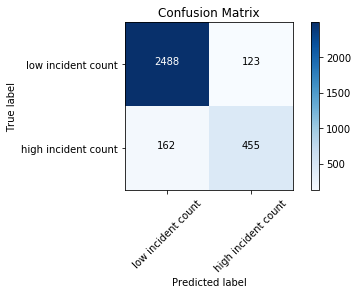

In [35]:
conf = confusion_matrix(y_val_clf, lr_y_hat)
ttl = "Confusion Matrix"
plot_confusion_matrix(conf, classes=["low incident count","high incident count"], title = ttl)
plt.show()

In [36]:
tpr = recall_score(y_val_clf, lr_y_hat)
acc = accuracy_score(y_val_clf, lr_y_hat)
print_txt = "Accuracy = {acc}\tTrue Positive Rate = {tpr}".format(acc=acc, tpr=tpr)
print(print_txt)

Accuracy = 0.9117100371747212	True Positive Rate = 0.7374392220421394


Our confusion matrix and the above breakdown of the elements of our composite score (accuracy and TPR) show that our best logistic model does quite well at predicting the majority class (low daily incidents per 25,000 residents) and significantly worse when predicting for the minority class.  In other words, our TPR dragged down the composite score.

In the context of our scenario, presenting these data to the APD, we would explain that a confusion matrix helps explain how confused our classifier is. A perfect classifier would have all predictions fall into the negatively sloped diagonal cells. This type of plot easily illuminates the accuracy, TPR, and composite score calculations, all of which can be derived from this simple plot.  

Next we plot ROC curves for both classes using the best logistic regression model.

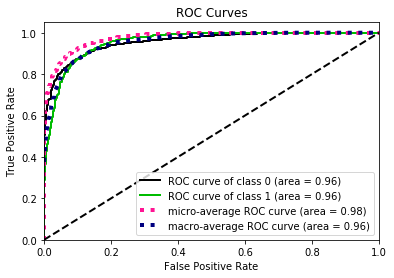

In [37]:
import scikitplot as skplt

y_probas = best_lr_clf.predict_proba(Xs_val_scl)
skplt.metrics.plot_roc(y_val_clf, y_probas)

plt.show()

The ROC curves figure above is a plot of the true positive rate (TPR) against the false positive rate (FPR) for different possible cutpoints (i.e. thresholds) of the probabilities output by the logistic function of our model.  This plot depicts the trade off between TPR and FPR, where increases in TPR will require an increase in the FPR.

The closer the curves get to the upper left corner and the top of the plot, the more accurate our classifier is.  Conversely, the closer the ROC curves get to the dashed 45$^{\circ}$ line, the more our binary classifier approaches a model which predicts as well as random chance.  In other words, the 45$^{\circ}$ represents "random coin flip classifier."

The area under the curve (AUC) is essentially a measure of how well our classifier can distinguish between the two classes.  As we see in the plot, our AUC is quite high for both classes at 0.96.

### Logistic Regression Best Model Feature Importance

In [38]:
feature_names = [col for col in df_test.drop(['high_loi', 'daily_incidents_per_25k_population'], axis=1).columns]
weights = best_lr_clf.coef_[0]
logreg_feature_importance_df = pd.DataFrame({'Feature_Name':feature_names,'Weights':weights})
logreg_feature_importance_df['Absolute_Weight'] = np.abs(weights)
logreg_feature_importance_df.sort_values('Absolute_Weight', inplace=True, ascending=False)


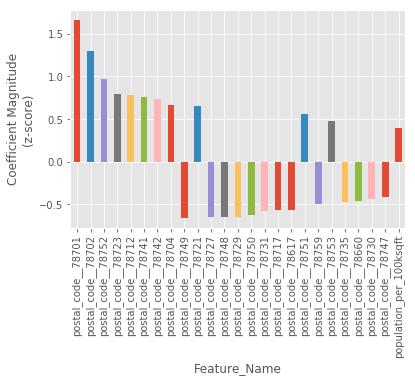

In [39]:
plt.style.use('ggplot')

wt_plt_df = logreg_feature_importance_df.head(25)

weights = pd.Series(wt_plt_df['Weights'].values,index=wt_plt_df['Feature_Name'])
ax = weights.plot(kind='bar')


ax.set_ylabel("Coefficient Magnitude\n(z-score)")
plt.show()


In examining the top 25 weights by absolute value, it is clear that location is the most important factor in determining level of daily incidents per 25,000 residents.

The importance of location makes quite a bit of sense. For instance, the most significant feature, postal code 78701, is Downtown Austin. This is a densely populated area with a large number of bars and night clubs. It would make sense that an area such as this, with a high population, would have a higher probability of a high frequency of incidents. Coupled with the fact that large numbers of persons are individuals consuming alcohol (often at high volumes), and you have a recipe for incidents to occur.

The next most significant feature is postal code 78702, an area just East of downtown Austin.  This area tends to be low income while also being more densely populated than much of the rest of Austin.  This area also has a higher concentration of nightlife establishments, likely leading to more frequent alcohol related incidents similar to Downtown.

The next 22 most significant features are all location based. These locations act as proxies for and encode information of other variables (which are not present in our data), such as population, population density, socioeconomics, and so on.

Finally, the 25th most significant feature is population per 100,000 square feet.  A more densely populated area seems to suggest a  higher probability of crime, even if the actual rate of crime remains the same as other locales, so this too makes sense as an influential feature.

---
## Random Forest

### General

The Random Forest algorithm is an ensemble method where multiple decision tree classifiers are aggregated together thereby improving accuracy.  The individual decision trees comprise a random sample of the observations and a random selection of the features.  A single decision trees is considered to be a “weak learner”; however, when a group of individual trees (a forest) come together and vote for a final result, that process creates a “strong learner.”

### Advantages of Random Forest

 - Random Forests are generally very accurate and are the workhorse of classification algorithms.  
 - They are faster to train because it selects a subset of predictors for each split this also improves the predictive power as the trees are therefore uncorrelated.  
 - They work well for large data sets because of the computational scalability.  
 - They also work well for data sets with high dimensionality and data sets with mixed data types.  
 - They specifically work well with categorical features having high cardinality (many possible values).  
 - They are robust to missing values in the data and outliers.  
 - From a modeling perspective they have relatively few hyperparameters to tune.  
 - The algorithm is not bound by linear constraints and will function with both linear and nonlinear data sets.  

### Disadvantages of Random Forest

 - Random Forests can be prone to overfitting on the training data and not generalizing well to testing data.  
 - Needs larger number of observations for the randomization inherent in the algorithm process to work well—at least a few hundred samples per class.  
 - They have poor predictive ability outside of the range of the features (extrapolation).


---
### Modeling

Instantiate a random forest classifier object. Note that we pass no parameters to the object as this will occur during the hyperparameter search conducted by the GridSearchCV object.

In [40]:
from sklearn.ensemble import RandomForestClassifier

# create the classifier instance
rfclf = RandomForestClassifier()

Create a dictionary of hyperparameter values that will be passed to the grid search function.  
`n_estimators` is the number of individual decision trees that will be created in the model.  
`criterion` is the method of determing best split and is either the gini value or entropy value.  
`max_depth` is the maximum depth of the decision trees or the maximum number of splits deep the tree is.  

A preliminary grid search was performed that is not shown here.  A broad range of hyperparameters were used which resulted in an extremely time consuming model search which was deemed to be beyond the scope of this analysis.  We have slightly simplified the parameter search which we feel in is accord with the scope of this analysis.  The number of estimators (n_estimators) was choosen as it sets the number of decision trees in the forest; which equates to how many weak learners are aggregated together to achieve the final classification.  We set n_estimators at 10 and 100, 10 being a relatively small number of trees versus the number of features in the data and 100 being a more normal value.  We would have liked to run the model using a much larger number of trees but these proved to be too resource intensive.  Criterion was choosen because this calculation drives the decison element of the decision tree.  While, gini and entropy are known to give similar values we wanted to know which was more effective in this analysis.  Maximum features selected at each split (max_features) is an important parameter in the model as it determines the amount of randomness in the creation of each tree.  We used the default square root of the maximum number of features and compared that to 131, which is the actual maximum number of features. 

In [41]:
# establish parameters for gridsearch
parameters = {'n_estimators': [10, 100]
    , 'criterion':["gini", "entropy"]
    , 'max_features':("sqrt", 131)
    }

Create a GridSearchCV object. In our configuration of this object, we pass it the "blank" random forest classifier, the StratifiedKFold object where $k=10$, the hyperparameter object from the previous cell, and the composite scorer we previously created. Additionally, we instruct the grid search object to execute two jobs simultaneously (i.e. parallel execution).

In [42]:
# create a grid search object
rf_clf = GridSearchCV(estimator=rfclf
                   , n_jobs=2 # parallel execution
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=skf # KFolds = 10
                   , scoring=comp_scorer)

Having created our grid search object, we now pass it training data and begin the hyperparameter search.

In [43]:
rf_clf.fit(Xs_trn_tst_scl, y_trn_tst_clf)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.1min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 13.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=24, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [10, 100], 'criterion': ['gini', 'entropy'], 'max_features': ('sqrt', 131)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(score_func), verbose=1)

With our grid search process complete, we can now look at models ranked according to their mean test score (where $n=k=10$). The grid search produced 8 models.

In [44]:
rndfst_results = pd.DataFrame(rf_clf.cv_results_)
rndfst_results.sort_values(by="rank_test_score", inplace=True)
headers = ['rank_test_score','mean_test_score','mean_train_score','param_n_estimators','param_criterion','param_max_features','std_test_score','std_train_score']
rndfst_results[headers].head(10)

,rank_test_score,mean_test_score,mean_train_score,param_n_estimators,param_criterion,param_max_features,std_test_score,std_train_score
7,1,0.746665,0.999955,100,entropy,131,0.086369,0.000033
6,2,0.733241,0.985104,10,entropy,131,0.084282,0.000780
3,3,0.724152,0.999968,100,gini,131,0.112965,0.000033
2,4,0.711291,0.985180,10,gini,131,0.108789,0.000665
5,5,0.695905,0.999939,100,entropy,sqrt,0.106161,0.000043
4,6,0.677528,0.985952,10,entropy,sqrt,0.112067,0.000828
1,7,0.647170,0.999968,100,gini,sqrt,0.135770,0.000036
0,8,0.638967,0.986134,10,gini,sqrt,0.128556,0.000698


Observations about the models:

The models have mean test scores ranging from 0.62 to 0.74.  From this table we can see a clear ordering of which hyperparameters influence the mean test score.  The hyperparameters in order of descending influence are maximum features per tree, split criterion, and number of estimators (trees).  When the random forest algorithm was allowed to select 131 features, which is the total number of features in the data set, versus the square root of the maximum features (default setting), it outperformed by approximately 500 basis points.  Entropy as the split criterion showed an increase over gini as the split criterion.  The larger number of estimators, 100 versus 10, showed improved performance.  Suprisingly, the number of estimators (trees) in each random forest was not the most influential hyperparamter in the model search.  We suspect that, given more time and resources, further increasing the number of estimators would increase its importance in the model and improve accuracy.

Next, we print the parameterization of the best estimator.

In [45]:
rf_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=131, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We instantiate a random forest classifier object using the parameters of the best model.

In [46]:
best_rf_clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=131, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

This new model is trained on the entire "train-test" set. After training, we predict against the validation set.

In [47]:
# fit the model with best parameters to ALL THE DATA!
best_rf_clf.fit(Xs_trn_tst_scl, y_trn_tst_clf)

# make predictions against unseen data (validation set)
rf_y_hat = best_rf_clf.predict(Xs_val_scl)

---
### Random Forest Best Model Evaluation

In [48]:
rf_comp_score = round(score_func(y_val_clf, rf_y_hat),4) * 100
print("The best random forest model produces a composite \nscore of {score}" 
      " out of 100 when predicting against the validation data set".format(score=rf_comp_score))

The best random forest model produces a composite 
score of 81.47999999999999 out of 100 when predicting against the validation data set


Confusion matrix, without normalization


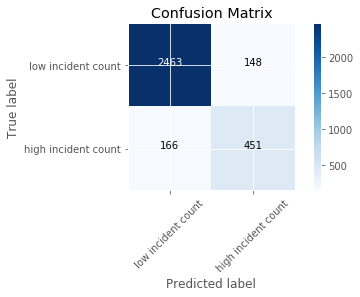

In [49]:
conf = confusion_matrix(y_val_clf, rf_y_hat)
ttl = "Confusion Matrix"
plot_confusion_matrix(conf, classes=["low incident count","high incident count"], title = ttl)
plt.show()

Our confusion matrix and the above breakdown of the elements of our composite score (accuracy and TPR) show that our best random forest model does quite well at predicting the majority class (low daily incidents per 25,000 residents) and significantly worse when predicting for the minority class. In other words, our TPR dragged down the composite score.


In the context of our scenario, were we to present these data to the APD, we would explain that a confusion matrix helps explain how confused our classifier is. They would be able to understand the weight of each cell in the matrix via color coding, and how a perfect classifier would all predictions fall into the negatively sloped diagonal cells. This plot also easily illuminates the accuracy, TPR, and composite score calculations, all of which can be derived from this simple plot.

Next we plot ROC curves for both classes using the best random forest model.

/Users/glennoswald/miniconda3/envs/gkopyenviro/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


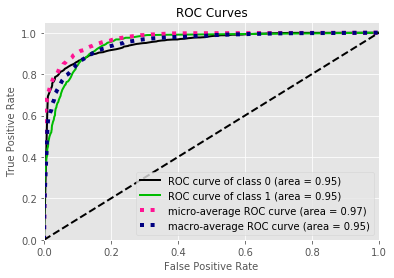

In [50]:
import scikitplot as skplt

y_probas = best_rf_clf.predict_proba(Xs_val_scl)
skplt.metrics.plot_roc_curve(y_val_clf, y_probas)

plt.show()

The ROC curve is explained in the logistic regression evaluation section.

The area under the curve (AUC) is essentially a measure of how well our classifier can distinguish between the two classes.  As we see in the plot, our AUC is quite high for both classes at $0.95$.

---
## AdaBoost

### General

The AdaBoost algorithm is an ensemble method where multiple weak learners are combined together to make a stronger prediction. Any weak learner can be used but for this project a decision tree was used. Each training iteration of the algorithm weights the predictions. Incorrect predictions are weighted higher on subsequent runs. This makes sure the boosting focuses on the incorrect predictions.

### Advantages of AdaBoost

-Rarely overfits  
-Runs fast as weak learners are quick to build.  
-Very accurate as it just needs a weak learner that is above 50% accurate.

### Disadvantages of AdaBoost

-Cannot be parallelized as each run depends on the results of the preceeding one  
-Tuning hyperparameters can be difficult.  
-AdaBoost is sensitive to outliers due to the weighting process.


---
### Modeling

First, an AdaBoost classifier must be created. A decision tree is chosen as the weak learner.

In [51]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))


Create a dictionary of hyperparameter values that will be passed to the grid search function:
 - `n_estimators` - the number of individual decision trees that will be created in the model.
 - `learning_rate` - the weight given to each classifier. Generally, a lower learning_rate requires more estimators.
 - `algorithm` - can be either the real or discrete form of SAMME (Stagewise Additive Modeling using Multiclass Exponential loss).

In [52]:
# establish parameters for gridsearch
parameters = {'n_estimators': [50,100]
    , 'learning_rate':[0.99,1.0]
    , 'algorithm':("SAMME", "SAMME.R")
    }

Create a GridSearchCV object. In our configuration of this object, we pass it the AdaBoost classifier, the StratifiedKFold object where k=10, the hyperparameter object from the previous cell, and the composite scorer we previously created. Additionally, we instruct the grid search object to execute four jobs simultaneously (i.e. parallel execution).

In [53]:
# create a grid search object
ab_clf = GridSearchCV(estimator=bdt
                   , n_jobs=4 # parallel execution
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=skf # KFolds = 10
                   , scoring=comp_scorer)

Having created our grid search object, we now pass it training data and begin the hyperparameter search.

In [54]:
ab_clf.fit(Xs_trn_tst_scl, y_trn_tst_clf)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  4.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=24, shuffle=False),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [50, 100], 'learning_rate': [0.99, 1.0], 'algorithm': ('SAMME', 'SAMME.R')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(score_func), verbose=1)

With our grid search process complete, we can now look at models ranked according to their mean test score (where $n=k=10$). The grid search produced 8 models.

In [55]:
ab_results = pd.DataFrame(ab_clf.cv_results_)
ab_results.sort_values(by="rank_test_score", inplace=True)
headers = ['rank_test_score','mean_test_score','mean_train_score','param_n_estimators','param_learning_rate','param_algorithm','std_test_score','std_train_score']
ab_results[headers].head(10)

,rank_test_score,mean_test_score,mean_train_score,param_n_estimators,param_learning_rate,param_algorithm,std_test_score,std_train_score
4,1,0.767691,0.878808,50,0.99,SAMME.R,0.153685,0.002853
6,2,0.762294,0.879004,50,1,SAMME.R,0.152482,0.002851
7,3,0.738027,0.880426,100,1,SAMME.R,0.143416,0.002300
5,4,0.733487,0.881129,100,0.99,SAMME.R,0.140449,0.002533
1,5,0.729977,0.764880,100,0.99,SAMME,0.059253,0.044324
3,6,0.716684,0.746936,100,1,SAMME,0.049204,0.042504
2,7,0.655197,0.674805,50,1,SAMME,0.064536,0.025971
0,8,0.653856,0.664343,50,0.99,SAMME,0.066655,0.035414


Observations about the models:

The models have mean test scores ranging from 0.66 to 0.77. There are some interesting findings in the grid search. First, the top two models only used 50 estimators. This is a strange finding as normally boosting gets progressively better with each iteration. Also, the real form of SAMME (SAMME.R) outperformed all of the SAMME algorithms. Lastly, the 0.9 learning rate did mostly better in all of them.    

Next, we print the parameterization of the best estimator.

In [56]:
ab_clf.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.99, n_estimators=50, random_state=None)

We instantiate an AdaBoost classifier object using the parameters of the best model.

In [57]:
best_ab_clf = AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.99, n_estimators=50, random_state=None)

This model then is fitted to all of the training data at once and then predictions made on the validation set.

In [58]:
# fit the model with best parameters to ALL THE DATA!
best_ab_clf.fit(Xs_trn_tst_scl, y_trn_tst_clf)

# make predictions against unseen data (validation set)
ab_y_hat = best_ab_clf.predict(Xs_val_scl)

---
### AdaBoost Best Model Evaluation

In [59]:
ab_comp_score = round(score_func(y_val_clf, ab_y_hat),4) * 100
print("The best AdaBoost model produces a composite \nscore of {score}" 
      " out of 100 when predicting against the validation data set".format(score=ab_comp_score))

The best AdaBoost model produces a composite 
score of 85.19 out of 100 when predicting against the validation data set


Confusion matrix, without normalization


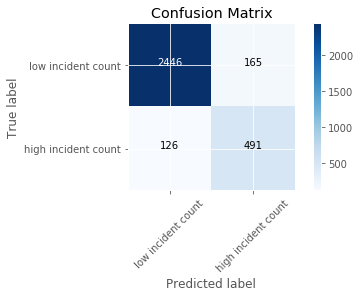

In [60]:
conf = confusion_matrix(y_val_clf, ab_y_hat)
ttl = "Confusion Matrix"
plot_confusion_matrix(conf, classes=["low incident count","high incident count"], title = ttl)
plt.show()

As our dataset has a class imbalance, simple accuracy is not the best way to evaluate a model. The confusion matrix will show how the model is handling classification by easily seeing all of the classifications.

In [61]:
tpr = recall_score(y_val_clf, ab_y_hat)
acc = accuracy_score(y_val_clf, ab_y_hat)
print_txt = "Accuracy = {acc}\tTrue Positive Rate = {tpr}".format(acc=acc, tpr=tpr)
print(print_txt)

Accuracy = 0.9098513011152416	True Positive Rate = 0.7957860615883307


/Users/glennoswald/miniconda3/envs/gkopyenviro/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


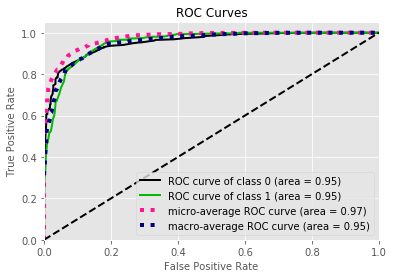

In [62]:
y_probas = best_ab_clf.predict_proba(Xs_val_scl)
skplt.metrics.plot_roc_curve(y_val_clf, y_probas)

plt.show()

The ROC curve is explained in the logistic regression evaluation section.

Each of the class curves has an area of 0.95 which is good performance.

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# Regression

---
## Multiple Linear Regression (Ordinary Least Squares Method)

---
### General  
The ordinary least squares (OLS) method of multiple linear regression is a statistical method for estimating unknown coefficients of multiple independent variables to predict the value of a single dependent (or target) variable.  The method achieves these estimates by attempting to minimize to the sum of squares of the model errors.  
 
### Advantages of Multiple Linear Regression  
 - Relatively simple and thus easier to interpret and thus explain relationships between independent and dependent variables.
 - Computationally efficient when compared to more complex methods.  Requires only linear algebra and thus is ideally suited for computers!

 
### Disadvantages of Multiple Linear Regression  
 - Models can be disrupted by outliers
 - Even after transformation, extreme instances of nonlinear independent variables may result in large errors (i.e. works best with linear inputs)
 - The further away from the data extrapolation is attempted, the more uncertain predictions become


---
## Modeling

Import the `mean_squared_error` function from `sklearn.metrics`.  Create a function which returns the $MAE$, then make that a function a scorer object so it can be passed to grid search.

In [63]:
from sklearn.metrics import mean_absolute_error

mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)

Instantiate `LinearRegression` object with default parameterization.

In [64]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

Establish hyperparameter space to be grid searched.

In [65]:
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

Create a GridSearchCV object. In our configuration of this object, we pass it the "blank" linear regressor, the KFold object where  $k=10$ , the hyperparameter search space object from the previous cell, and the $MAE$ scorer we previously created. Additionally, we instruct the grid search object to execute two jobs simultaneously (i.e. parallel execution).

In [66]:
linreg_clf = GridSearchCV(estimator=linreg
                   , n_jobs=2 # parallel execution
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   #, cv=skf # KFolds = 10
                    , cv=10 # KFolds = 10
                   , scoring=mae_scorer)

Having created our grid search object, we now pass it training data and begin the hyperparameter search.

In [67]:
linreg_clf.fit(Xs_trn_tst_scl, y_trn_tst_reg)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    9.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

With our grid search process complete, we can now look at the models ranked according to their mean test score (where $n=k=10$). Our grid search produced 4 models, few enough that we can display them all.

In [68]:
linreg_results = pd.DataFrame(linreg_clf.cv_results_)
linreg_results.sort_values(by="rank_test_score", inplace=True)
headers = ['rank_test_score','mean_test_score','mean_train_score','param_fit_intercept','param_normalize','std_test_score','std_train_score']
linreg_results[headers].head(10)

,rank_test_score,mean_test_score,mean_train_score,param_fit_intercept,param_normalize,std_test_score,std_train_score
2,1,-1.009039e+02,-9.338252,False,True,6.236717e+01,5.043087
3,1,-1.009039e+02,-9.338252,False,False,6.236717e+01,5.043087
1,3,-3.238051e+11,-4.306109,True,False,8.084608e+11,0.047545
0,4,-4.340414e+12,-4.302157,True,True,5.046136e+12,0.047183


Observations about linear models produced by grid search:
 - The `mean_test_score` and `mean_train_score` fields are negated as an artifact of `sklearn`'s internals.  The true mean $MAE$ for each model is obtained by reversing this negation.  So the top ranked model's `mean_test_score` is actually $2.522540e+10$ and its `mean_train_score` is actually $4.305920e+00$.
 - The `mean_test_score`s are incredibly large for $MAE$.  As we will soon see, these don't seem to correspond to the actual performance of the estimators.
 - The top ranked estimator's `mean_test_score` is two orders of magnitude better than the next ranked estimator.

Next, we print the parameterization of the best estimator.

In [69]:
linreg_clf.best_estimator_

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

We instantiate a linear regression object using the parameters of the best model.

In [70]:
best_linreg_clf = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

This new model is trained on the entire "train-test" set.  After training, we predict against the validation set.

In [71]:
# train on all of the "train-test" data
best_linreg_clf.fit(Xs_trn_tst_scl, y_trn_tst_reg)

# make predictions against unseen data (validation set)
linreg_y_hat = best_linreg_clf.predict(Xs_val_scl)

---
### Multiple Linear Regression Best Model Evaluation

First, we will calculate the $MAE$, our chosen metric, for the best model's predictions against the validation data set.

In [72]:
mae = mean_absolute_error(y_val_reg, linreg_y_hat)
print_str = "The MAE of the predictions is {mae}."
print(print_str.format(mae=mae))

The MAE of the predictions is 4.8829295276456905.


Recall that $MAE$ is in the units of the original data.  This means that our "average error" has about one quarter the  magnitude of our high/low threshold cutpoint ($17$).

 Next we'll build a sampling distribution of the $MAE$ via bootstrap.

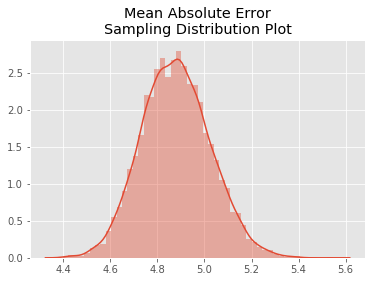

The mean of the distribution is 4.878550009199882
The median of the distribution is 4.875635783140165


In [73]:
from sklearn.utils import resample

mae_li = [] # an empty list
n_samples = len(y_val_reg) # large same equal to validation set size, but w/ replacement!

for i in range(10000): # 10,000 samples
    X_samp, y_true = resample(Xs_val_scl, y_val_reg, replace=True, n_samples=n_samples)
    y_pred = best_linreg_clf.predict(X_samp)
    mae = mean_absolute_error(y_true, y_pred)
    mae_li.append(mae)
    
sns.distplot(mae_li).set_title("Mean Absolute Error\nSampling Distribution Plot")  
plt.show()

print("The mean of the distribution is {mean}".format(mean=np.mean(mae_li)))
print("The median of the distribution is {median}".format(median=np.median(mae_li)))

This distribution is has low spread and looks very symmetric. Let's examine its five number summary.

In [74]:
linreg_mae_df = pd.DataFrame({"sample_mae":mae_li})
linreg_mae_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_mae,10000.0,4.87855,0.145103,4.397075,4.778033,4.875636,4.975133,5.54436


Calculate a 95% confidence interval for the $MAE$ using our bootstrapped frequency distribution.

In [75]:
x_bar = round(linreg_mae_df.describe().T['mean'].values[0],2)
fifth = round(np.percentile(mae_li, 5),2)
ninety_fifth = round(np.percentile(mae_li, 95),2)


print("The 95% confidence interval for the mean {mean} is {low} to {high}.".format(mean=x_bar, low=fifth, high=ninety_fifth))


The 95% confidence interval for the mean 4.88 is 4.65 to 5.12.


These results strongly suggest that if future data are similar to the validation set (something we would not necessarly expect), the $MAE$ is likely to be around $4.5$, or $25\%$ of our high/low cutpoint of 17.  We would have to consult our domain experts at the APD to deterimine if this magnitude of average error would be acceptable when predicting the continuous variable of daily incidents per 25,000 residents.

---
### Linear Regression Feature Importance

In [76]:
weights = best_linreg_clf.coef_
feature_names = df_test.drop(labels=['daily_incidents_per_25k_population','high_loi'], axis=1).columns
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='weights', inplace=True)

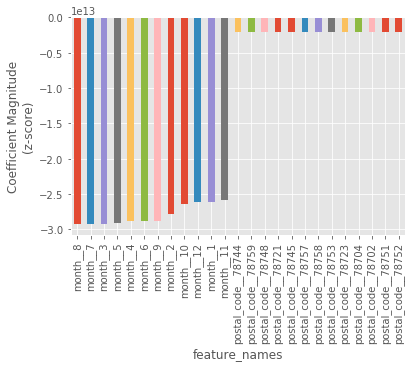

In [77]:
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(25)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')


ax.set_ylabel("Coefficient Magnitude\n(z-score)")
plt.show()


Interestingly, this model finds time variables to be most significant.  The first 8 most signifanct features are the months August, July, March, May, April, June, September, and February. These the weights of these features are very similar, and all negative in sign.

The next seven most significant variables are then each day of the week (not in order), followed by the remaining months of the year.  The magnitude of the next most significance drops by more than half, with the remaining features being comprised of days of the month.


It is tempting to conclude that some notions of seasonality or other temporally driven phenomena may contribute to this set of weights, but it seems that the linear regression model may simply be heavily weighting indicator variables with the fewest levels.

---
## Stochast Gradient Descent for Linear Regression

---
### General  
"The class SGDRegressor implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties to fit linear regression models. SGDRegressor is well suited for regression problems with a large number of training samples (> 10.000)..." [6]

### Advantages  
 - Efficiency. [6]  
 - Ease of implementation (lots of opportunities for code tuning). [6]  
 
### Disadvantages
 - SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations. [6] 
 - SGD is sensitive to feature scaling. [6]  

---
## Modeling

Instantiate `SGDRegressor` object with default parameterization.

In [78]:
from sklearn.linear_model import SGDRegressor

sgdreg = SGDRegressor()

Establish hyperparameter space to be grid searched.

In [79]:
parameters = {'learning_rate':('optimal','constant'), 'eta0':(.00001, .0001, .001, .01)}

Create a GridSearchCV object. In our configuration of this object, we pass it the "blank" SGD regressor, the KFold object where  $k=10$ , the hyperparameter search space object from the previous cell, and the $MAE$ scorer we previously created. Additionally, we instruct the grid search object to execute two jobs simultaneously (i.e. parallel execution).

In [80]:
sgdreg_clf = GridSearchCV(estimator=sgdreg
                   , n_jobs=2 # parallel execution
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   #, cv=skf # KFolds = 10
                    , cv=10 # KFolds = 10
                   , scoring=mae_scorer)

Having created our grid search object, we now pass it training data and begin the hyperparameter search.

In [81]:
sgdreg_clf.fit(Xs_trn_tst_scl, y_trn_tst_reg)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   15.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'learning_rate': ('optimal', 'constant'), 'eta0': (1e-05, 0.0001, 0.001, 0.01)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

With our grid search process complete, we can now look at the models ranked according to their mean test score (where $n=k=10$). Our grid search produced 8 models, few enough that we can display them all.

In [82]:
sgdreg_results = pd.DataFrame(sgdreg_clf.cv_results_)
sgdreg_results.sort_values(by="rank_test_score", inplace=True)
headers = ['rank_test_score','mean_test_score','mean_train_score','param_learning_rate','param_eta0','std_test_score','std_train_score']
sgdreg_results[headers].head(10)

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_eta0,std_test_score,std_train_score
3,1,-4.901447e+00,-6.168560e+00,constant,0.0001,4.820400e-01,8.041704e-01
1,2,-5.477800e+00,-4.363899e+00,constant,1e-05,5.785997e-01,5.686136e-02
5,3,-8.724868e+09,-1.120814e+10,constant,0.001,2.643508e+09,2.043158e+09
7,4,-1.632509e+11,-1.833719e+11,constant,0.01,1.750193e+10,2.693341e+10
0,5,-1.836336e+12,-1.984752e+12,optimal,1e-05,1.195057e+11,1.101468e+11
2,6,-1.943173e+12,-2.057901e+12,optimal,0.0001,2.007035e+11,1.721918e+11
4,7,-1.953482e+12,-2.086138e+12,optimal,0.001,2.483476e+11,1.310589e+11
6,8,-1.965703e+12,-1.986248e+12,optimal,0.01,2.716762e+11,1.231879e+11


Observations about linear models produced by grid search using stochastic gradient descent:
 - The `mean_test_score` and `mean_train_score` fields are negated as an artifact of `sklearn`'s internals.  The true mean $MAE$ for each model is obtained by reversing this negation.  So the top ranked model's `mean_test_score` is actually $1.194882e+01$ or $11.95$ and its `mean_train_score` is actually $1.454625e+01$ or $14.55$.
 - The top two `mean_test_score`s have much smaller $MAE$ than we saw with linear regression.
 - The top ranked estimator's `mean_test_score` very, very close to the runner up.  Choosing one over the other on the basis of these score's is really an arbitrary decision.
 - Configurations where `learning_rate` is set to `constant` always beat those where it is set to `optimal` in this grid seach.
 - The ranking of the `eta0` parameter does not seem to be  patternistic.

Next, we print the parameterization of the best estimator.

In [83]:
sgdreg_clf.best_estimator_

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0001,
       fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

We instantiate a linear regression object using the parameters of the best model.

In [84]:
sgdreg_best = SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=1e-05,
       fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

This new model is trained on the entire "train-test" set. After training, we predict against the validation set.

In [85]:
# train on all of the "train-test" data
sgdreg_best.fit(Xs_trn_tst_scl, y_trn_tst_reg)

# make predictions against unseen data (validation set)
sgdreg_y_hat = sgdreg_best.predict(Xs_val_scl)

---
### Linear Regression Using SGD Best Model Evaluation

First, we will calculate the $MAE$, our chosen metric, for the best model's predictions against the validation data set.

In [86]:
mae = mean_absolute_error(y_val_reg, sgdreg_y_hat)
print_str = "The MAE of the predictions is {mae}."
print(print_str.format(mae=mae))

The MAE of the predictions is 4.421884960000037.


Once again our "average error" has about one quarter the  magnitude of our high/low threshold cutpoint ($17$).

Next we bootstrap a sampling distribution of the MAE.

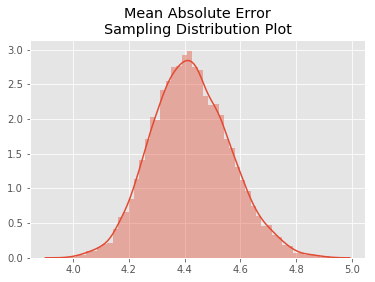

The mean of the distribution is 4.422068711643743
The median of the distribution is 4.417170228574053


In [87]:
from sklearn.utils import resample

mae_li = [] # an empty list
n_samples = len(y_val_reg) # large same equal to validation set size, but w/ replacement!

for i in range(10000): # 10,000 samples
    X_samp, y_true = resample(Xs_val_scl, y_val_reg, replace=True, n_samples=n_samples)
    y_pred = sgdreg_best.predict(X_samp)
    mae = mean_absolute_error(y_true, y_pred)
    mae_li.append(mae)
    
sns.distplot(mae_li).set_title("Mean Absolute Error\nSampling Distribution Plot")  
plt.show()

print("The mean of the distribution is {mean}".format(mean=np.mean(mae_li)))
print("The median of the distribution is {median}".format(median=np.median(mae_li)))

As we would expect from the central limit theorem, a very nice, normal looking frequency distribution is created.

In [88]:
sgdreg_mae_df = pd.DataFrame({"sample_mae":mae_li})
sgdreg_mae_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_mae,10000.0,4.422069,0.140214,3.970436,4.325096,4.41717,4.515026,4.922592


Calculate a 95% confidence interval for the $MAE$ using our bootstrapped frequency distribution.

In [89]:
x_bar = round(sgdreg_mae_df.describe().T['mean'].values[0],2)
fifth = round(np.percentile(mae_li, 5),2)
ninety_fifth = round(np.percentile(mae_li, 95),2)


print("The 95% confidence interval for the mean {mean} is {low} to {high}.".format(mean=x_bar, low=fifth, high=ninety_fifth))


The 95% confidence interval for the mean 4.42 is 4.2 to 4.66.


These results strongly suggest that if future data are similar to the validation set (something we would not necessarly expect), the $MAE$ is likely to be around $4.4$, or $25\%$ of our high/low cutpoint of 17.  We would have to consult our domain experts at the APD to deterimine if this magnitude of average error would be acceptable when predicting the continuous variable of daily incidents per 25,000 residents.

---
### SGD Feature Importance

In [90]:
weights = sgdreg_best.coef_
feature_names = df_test.drop(labels=['daily_incidents_per_25k_population','high_loi'], axis=1).columns
sgdreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
sgdreg_ft_imp_df.sort_values(by='weights', inplace=True)

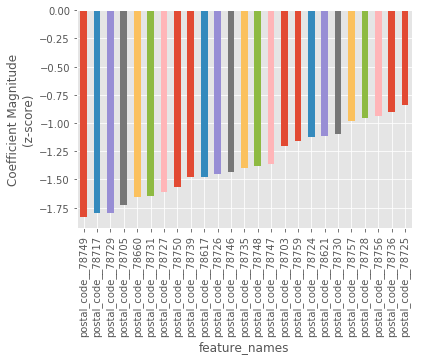

In [91]:
plt.style.use('ggplot')

wt_plt_df = sgdreg_ft_imp_df.head(25)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar')


ax.set_ylabel("Coefficient Magnitude\n(z-score)")
plt.show()


This model seems to have taken the approach of finding those postal codes with low crime and assigning them large negative coefficients.  78749 is a suburban area on the southern border of Austin full of shopping centers.  78729 is in North Austin, also suburban, containing many major corporate campuses including Apple, Dun & Bradstreet, and Oracle.  78717 is even further North and is solidly middle class and suburban.  In other words, the most important features are a line up of suburban, middle class, low crime areas.

---
## Multilayer Perceptron Regressor

---
### General  
A multiplayer perceptron (MLP) is a type of artificial neural network that consists of at least three layers of nodes.  The first layer is the input layer and the last layer is the output layer.  Excluding the input node, the inner layers use a nonlinear activation function such as linear regression.  

### Advantages  
 - Capability to learn non-linear models
 - No assumptions made as to the underlying probability density functions of data
 
 
### Disadvantages
 - MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy. [10]
 - MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations. [10]  
 - MLP is sensitive to feature scaling. [10]  

---
## Modeling

In [92]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor()

Establish hyperparameter space to be grid searched.

In [93]:
parameters = {'solver':['adam','sgd']
              ,'learning_rate':['adaptive']
              ,'hidden_layer_sizes':[10,30]
              ,'activation':['logistic','tanh']}

Create a GridSearchCV object. In our configuration of this object, we pass it the "blank" MLP regressor, the `StratifiedKFold` object where  $k=10$, the hyperparameter search space object from the previous cell, and the $MAE$  scorer we previously created. Additionally, we instruct the grid search object to execute four jobs simultaneously (i.e. parallel execution).

In [94]:
mlp_reg_gsc = GridSearchCV(estimator=mlp_reg
                   , n_jobs=4
                   , verbose=1
                   , param_grid=parameters
                   , scoring=mae_scorer
                   , cv=10
                   , return_train_score=False)

Having created our grid search object, we now pass it training data and begin the hyperparameter search.

In [95]:
mlp_reg_gsc.fit(Xs_trn_tst_scl, y_trn_tst_reg)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 16.3min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'solver': ['adam', 'sgd'], 'learning_rate': ['adaptive'], 'hidden_layer_sizes': [10, 30], 'activation': ['logistic', 'tanh']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

With our grid search process complete, we can now look at the models ranked according to their mean test score (where $n=k=10$). Our grid search produced 8 models, few enough that we can display them all.

In [96]:
mlpreg_results = pd.DataFrame(mlp_reg_gsc.cv_results_)
mlpreg_results.sort_values(by="rank_test_score", inplace=True)
headers = ['rank_test_score','mean_test_score','param_activation','param_hidden_layer_sizes','param_learning_rate','param_solver','std_test_score']
mlpreg_results[headers].head(10)
# mlpreg_results.head(10)
# mlpreg_results.columns

,rank_test_score,mean_test_score,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,std_test_score
5,1,-4.189610,tanh,10,adaptive,sgd,0.413538
4,2,-4.241963,tanh,10,adaptive,adam,0.256465
6,3,-4.276307,tanh,30,adaptive,adam,0.204079
1,4,-4.284572,logistic,10,adaptive,sgd,0.714993
2,5,-4.518160,logistic,30,adaptive,adam,0.317624
3,6,-4.963965,logistic,30,adaptive,sgd,0.728820
7,7,-5.011016,tanh,30,adaptive,sgd,0.723841
0,8,-5.526246,logistic,10,adaptive,adam,0.396942


Observations about linear models produced by grid search:
 - The `mean_test_score` field is negated as an artifact of `sklearn`'s internals.  The true mean $MAE$ for each model is obtained by reversing this negation.  So the top ranked model's `mean_test_score` is actually $4.151721$.
 - The `mean_test_score` results have very similar scores.
 - The top scoring configurations tended to have a `hidden_layer_size` of 10.
 - The `solver` configuration looks evenly distribued in terms of top scores between `sgd` and `adam`


Next, we print the parameterization of the best estimator.

In [97]:
mlp_reg_gsc.best_estimator_

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

We instantiate a `MLPRegressor` model using the best estimator configuration.

In [98]:
mlpreg_best = MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

This new model is trained on the entire "train-test" set. After training, we predict against the validation set.

In [99]:
# train on all of the "train-test" data
mlpreg_best.fit(Xs_trn_tst_scl, y_trn_tst_reg)

# make predictions against unseen data (validation set)
mlpreg_y_hat = mlpreg_best.predict(Xs_val_scl)

---
### Multilayer Perceptron Best Model Evaluation

First, we will calculate the $MAE$, our chosen metric, for the best model's predictions against the validation data set.

In [100]:
mae = mean_absolute_error(y_val_reg, mlpreg_y_hat)
print_str = "The MAE of the predictions is {mae}."
print(print_str.format(mae=mae))

The MAE of the predictions is 3.9614739072405865.


Our "average error" has about one third the magnitude of our high/low threshold cutpoint ($17$).

Next we bootstrap a sampling distribution of the MAE.

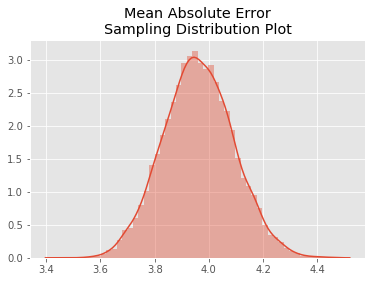

The mean of the distribution is 3.961481521097959
The median of the distribution is 3.9592502916844783


In [101]:
from sklearn.utils import resample

mae_li = [] # an empty list
n_samples = len(y_val_reg) # large same equal to validation set size, but w/ replacement!

for i in range(10000): # 10,000 samples
    X_samp, y_true = resample(Xs_val_scl, y_val_reg, replace=True, n_samples=n_samples)
    y_pred = mlpreg_best.predict(X_samp)
    mae = mean_absolute_error(y_true, y_pred)
    mae_li.append(mae)
    
sns.distplot(mae_li).set_title("Mean Absolute Error\nSampling Distribution Plot")  
plt.show()

print("The mean of the distribution is {mean}".format(mean=np.mean(mae_li)))
print("The median of the distribution is {median}".format(median=np.median(mae_li)))

As we would expect from the central limit theorem, a very nice, normal looking frequency distribution is created.

In [102]:
mlpreg_mae_df = pd.DataFrame({"sample_mae":mae_li})
mlpreg_mae_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_mae,10000.0,3.961482,0.129612,3.462246,3.873249,3.95925,4.048924,4.454691


Calculate a 95% confidence interval for the $MAE$ using our bootstrapped frequency distribution.

In [103]:
x_bar = round(mlpreg_mae_df.describe().T['mean'].values[0],2)
fifth = round(np.percentile(mae_li, 5),2)
ninety_fifth = round(np.percentile(mae_li, 95),2)


print("The 95% confidence interval for the mean {mean} is {low} to {high}.".format(mean=x_bar, low=fifth, high=ninety_fifth))


The 95% confidence interval for the mean 3.96 is 3.75 to 4.18.


These results strongly suggest that if future data are similar to the validation set (something we would not necessarly expect), the $MAE$ is likely to be around $5.6$, or $33\%$ of our high/low cutpoint of 17.  We would have to consult our domain experts at the APD to deterimine if this magnitude of average error would be acceptable when predicting the continuous variable of daily incidents per 25,000 residents.

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>
# Final Model Comparison

---
## Classification

We compare the best classifications models.  We predict against 10 folds from the validation set.

In [104]:
skf.get_n_splits(Xs_val_scl , y_val_clf)

lr_cs_tot = []
rf_cs_tot = []
ab_cs_tot = []

for train_index, test_index in skf.split(Xs_val_scl, y_val_clf):
    y_hat_lr = best_lr_clf.predict(Xs_val_scl[train_index])
    y_hat_rf = best_rf_clf.predict(Xs_val_scl[train_index])
    y_hat_ab = best_ab_clf.predict(Xs_val_scl[train_index])
    lr_cs_tot.append(score_func(y_val_clf[train_index], y_hat_lr))
    rf_cs_tot.append(score_func(y_val_clf[train_index], y_hat_rf))
    ab_cs_tot.append(score_func(y_val_clf[train_index], y_hat_ab))
    
print(ab_cs_tot)

[0.8556740475630138, 0.8597314443507882, 0.8509728215455747, 0.8606573749256321, 0.8491134812254173, 0.8460861272537661, 0.8475853176786252, 0.8515121291496421, 0.8505842853784467, 0.8474649920819384]


Create boxplot chart of results.

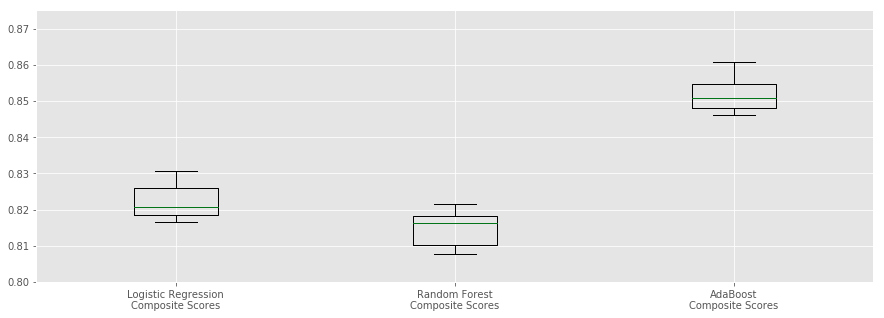

In [105]:
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([ lr_cs_tot, rf_cs_tot, ab_cs_tot],
            labels=['Logistic Regression\nComposite Scores','Random Forest\nComposite Scores', 'AdaBoost\nComposite Scores'])
plt.ylim([0.8,.875])
plt.show()


Conduct overall $F$-test to determine if the mean composite scores from the models are statistically significantly different.

In [106]:
from scipy import stats

F, p = stats.f_oneway(lr_cs_tot, rf_cs_tot, ab_cs_tot)

print("The F-statistic from the ANOVA test is {stat}".format(stat=F))
print("The p-value from the ANOVA test is {stat}".format(stat=p))

The F-statistic from the ANOVA test is 151.71807863793475
The p-value from the ANOVA test is 2.0688486277158473e-15


The very small $p$-value suggests that at least one model's mean composite score is different than the others.

We will need to conduct individual two sample $t$-tests to determine which is mean is the lowest. We will set our alpha to $0.05 / 3 = .017$ (Bonferroni adjustment).

In [107]:
t1, p1 = stats.ttest_ind(lr_cs_tot,rf_cs_tot, equal_var = False)
t2, p2 = stats.ttest_ind(lr_cs_tot,ab_cs_tot, equal_var = False)
t3, p3 = stats.ttest_ind(rf_cs_tot, ab_cs_tot, equal_var = False)

print("The t-stat and p-value for Logistic Regression model vs. Random Forest model are {t} and {p}".format(t=t1, p=p1))
print("The t-stat and p-value for Logistic Regression model vs. AdaBoost model are {t} and {p}".format(t=t2, p=p2))
print("The t-stat and p-value for Random Forest model vs.  AdaBoost model are {t} and {p}".format(t=t3, p=p3))

The t-stat and p-value for Logistic Regression model vs. Random Forest model are 3.440901247090314 and 0.002936131900357556
The t-stat and p-value for Logistic Regression model vs. AdaBoost model are -12.792196387565248 and 1.796520001264248e-10
The t-stat and p-value for Random Forest model vs.  AdaBoost model are -16.763413168215568 and 2.1231507232031245e-12


From the above $t$-tests we can conclude that AdaBoost provides the best composite scores.

---
## Regression

In [108]:
Xs_val_scl.shape

(3228, 131)

In [109]:
y_val_reg.shape

(3228,)

In [110]:
from sklearn.utils.multiclass import type_of_target

type_of_target(y_val_reg)

'continuous'

In [111]:
Xs_zeros = np.zeros(3228)

In [112]:
type_of_target(y_val_clf)

'binary'

In [113]:
skf.get_n_splits(Xs_val_scl , y_val_reg)

mlr_mae_tot = []
sgd_mae_tot = []
mlp_mae_tot = []

for train_index, test_index in skf.split(Xs_val_scl, y_val_clf):
    y_hat_mlr = best_linreg_clf.predict(Xs_val_scl[train_index])
    y_hat_sgd = sgdreg_best.predict(Xs_val_scl[train_index])
    y_hat_mlp = mlpreg_best.predict(Xs_val_scl[train_index])
    mlr_mae_tot.append(mean_absolute_error(y_val_clf[train_index], y_hat_mlr))
    sgd_mae_tot.append(mean_absolute_error(y_val_clf[train_index], y_hat_sgd))
    mlp_mae_tot.append(mean_absolute_error(y_val_clf[train_index], y_hat_mlp))

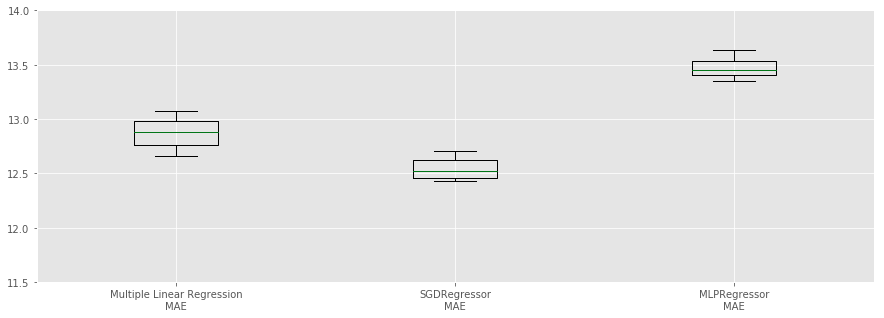

In [114]:
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([ mlr_mae_tot, sgd_mae_tot, mlp_mae_tot],
            labels=['Multiple Linear Regression\nMAE','SGDRegressor\nMAE', 'MLPRegressor\nMAE'])
plt.ylim([11.5, 14])
plt.show()

Conduct overall $F$-test to determine if the mean composite scores from the models are statistically significantly different.

In [115]:
from scipy import stats

F, p = stats.f_oneway(mlr_mae_tot,sgd_mae_tot,mlp_mae_tot)

print("The F-statistic from the ANOVA test is {stat}".format(stat=F))
print("The p-value from the ANOVA test is {stat}".format(stat=p))

The F-statistic from the ANOVA test is 168.23326270682523
The p-value from the ANOVA test is 5.716644099283768e-16


The boxplot above clearly shows that the MLPRegressor has a larger $MAE$ than either the Multiple Linear Regressor or the SGDRegressor. The ANOVA confrms this separation and the very small $p$-value statistically confirms that at least one model's mean $MAE$ is different than the others.

We conduct pairwise two sample $t$-tests to determine which is mean is indeed the lowest. We set our alpha to $0.05 / 3 = .017$ (Bonferroni adjustment).

In [116]:
t1, p1 = stats.ttest_ind(mlr_mae_tot,sgd_mae_tot, equal_var = False)
t2, p2 = stats.ttest_ind(mlr_mae_tot,mlp_mae_tot, equal_var = False)
t3, p3 = stats.ttest_ind(sgd_mae_tot,mlp_mae_tot, equal_var = False)

print("The t-stat and p-value for MLR vs. SGDRegressor are {t} and {p}".format(t=t1, p=p1))
print("The t-stat and p-value for MLR vs. MLPRegressor are {t} and {p}".format(t=t2, p=p2))
print("The t-stat and p-value for SGDRegressor vs. MLPRegressor are {t} and {p}".format(t=t3, p=p3))

The t-stat and p-value for MLR vs. SGDRegressor are 6.1907111104335355 and 1.3156582835320053e-05
The t-stat and p-value for MLR vs. MLPRegressor are -10.805153583610856 and 1.045919931318993e-08
The t-stat and p-value for SGDRegressor vs. MLPRegressor are -21.3246849837779 and 3.1895190158813764e-14


The $t$-tests again confirm that the $MAE$ for the MLPRegressor is greater than both the SGDRegressor and the Multiple Linear Regressor. The $t$-tests also show that the $MAE$ of the SGDRegressor is indeed the lowest of the three regresseion methods.

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>
# Deployment

The Austin Police Department (APD) has asked us to predict crime levels for postal codes in the Austin area for the fourth quarter of 2015.  We were provided with historical data for the period 2011 to the present.  We utilized 3 classification algorithms and 3 regression algorithms.

The classification algorithm was designed to assign postal code into groups of high or low crime rate areas.  The regression algorithm was designed to calculate a specific level of expected crime per postal code for every 25,000 people.

Given that we are using three months of forecasted data to create our predictions, we feel that the more general binary classification levels of high and low to be more useful for long-term planning.  We feel that using the exact crime levels that the regression calculates would be unnecessarily precise.  We expect that the APD would allocate equal resources to all high crime areas in an effort not to underserve those constituents.  In effect they would be replicating the cut-point between high and low that we created for the classification algorithms.

We recommend using a rolling system of updating both the historical training data and the forecast data on either a monthly or quarterly basis.  Then retraining the classification algorithm to determine the new high/low designations for each postal code.      

We do think the regression predictions could serve a specific purpose in a deployment plan.  The APD could use the regression algorithm to do ad hoc predictions for holidays, long weekends, or city-wide events.  More narrowly constrained, and accurate, forecasted data could be used as the testing data and drill down to more exact predicted crime levels that could be used to allocate extra or emergency resources to specific postal codes.



<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# References

[1] Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." In International Conference on Machine Learning, pp. 448-456. 2015.
Harvard  
[2] Kohavi, Ron. "A study of cross-validation and bootstrap for accuracy estimation and model selection." In Ijcai, vol. 14, no. 2, pp. 1137-1145. 1995.  
[3] https://www.quora.com/What-are-the-advantages-of-logistic-regression-over-decision-trees-Are-there-any-cases-where-its-better-to-use-logistic-regression-instead-of-decision-trees#!n=24  
[4] https://www.quora.com/What-are-the-pros-and-cons-of-using-logistic-regression-with-one-binary-outcome-and-several-binary-predictors  
[5] Faber, Nicolaas Klaas M. "Estimating the uncertainty in estimates of root mean square error of prediction: application to determining the size of an adequate test set in multivariate calibration." Chemometrics and intelligent laboratory systems 49, no. 1 (1999): 79-89.
Harvard	
[6] Pedregosa, F., G. Varoquaux, and A. Gramfort. "1.5. Stochastic Gradient Descent." 1.5. Stochastic Gradient Descent — scikit-learn 0.19.1 documentation. Accessed October 26, 2017. http://scikit-learn.org/stable/modules/sgd.html#sgd.  
[7]  Willmott, Cort J., and Kenji Matsuura. "Advantages of the mean absolute error (MAE) over the root mean square error (RMSE) in assessing average model performance." Climate research 30, no. 1 (2005): 79-82.  
[8] Willmott, Cort J., and Kenji Matsuura. "On the use of dimensioned measures of error to evaluate the performance of spatial interpolators." International Journal of Geographical Information Science 20, no. 1 (2006): 89-102.  
[9] Wesner, Janet. "MAE and RMSE - Which Metric is Better? – Human in a Machine World." Medium. March 23, 2016. Accessed October 28, 2017. https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d.  
[10] "1.17. Neural network models (supervised)¶." 1.17. Neural network models (supervised) — scikit-learn 0.19.1 documentation. Accessed October 29, 2017. http://scikit-learn.org/stable/modules/neural_networks_supervised.html.